In [10]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1

import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import itertools
import xarray

In [11]:

model="GAM" 
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']


taxas =["Amphibians"]
dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/Amphibians/EWEMBI/"
available_file = os.listdir(dir_species)
available_names = [x.split("_[1146].nc")[0] for x in available_file]


species_names = available_names[:1]

In [12]:
#newvalue

def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
    newvalue_dict = {model_name: {} for model_name in model_names}
    sum_bin_dict = {model_name: {} for model_name in model_names}

    for model_name in model_names:
        for species_name in species_names:
            if is_historical:
                ds = xr.open_dataset(netcdf_path_format.format(model, species_name, time), decode_times=False)
            else:
                ds = xr.open_dataset(netcdf_path_format.format(model, model_name, scenario, species_name, time), decode_times=False)
            newvalue = ds["newvalue"]
            sum_bin = ds["sum_bin"]

            newvalue_dict[model_name][species_name] = newvalue
            sum_bin_dict[model_name][species_name] = sum_bin

    projections_dict = {}

    for species_name in species_names:
        value_list = []
        for model_name in model_names:
            value_bin = newvalue_dict[model_name][species_name]
            value_list.append(value_bin)
        value_bin_concat = xr.concat(value_list, dim="model")
        mean_value_bin = value_bin_concat.mean(dim="model")
        projections_dict[species_name] = mean_value_bin

    value_bin_list = list(projections_dict.values())
    mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

    return mean_value_bin


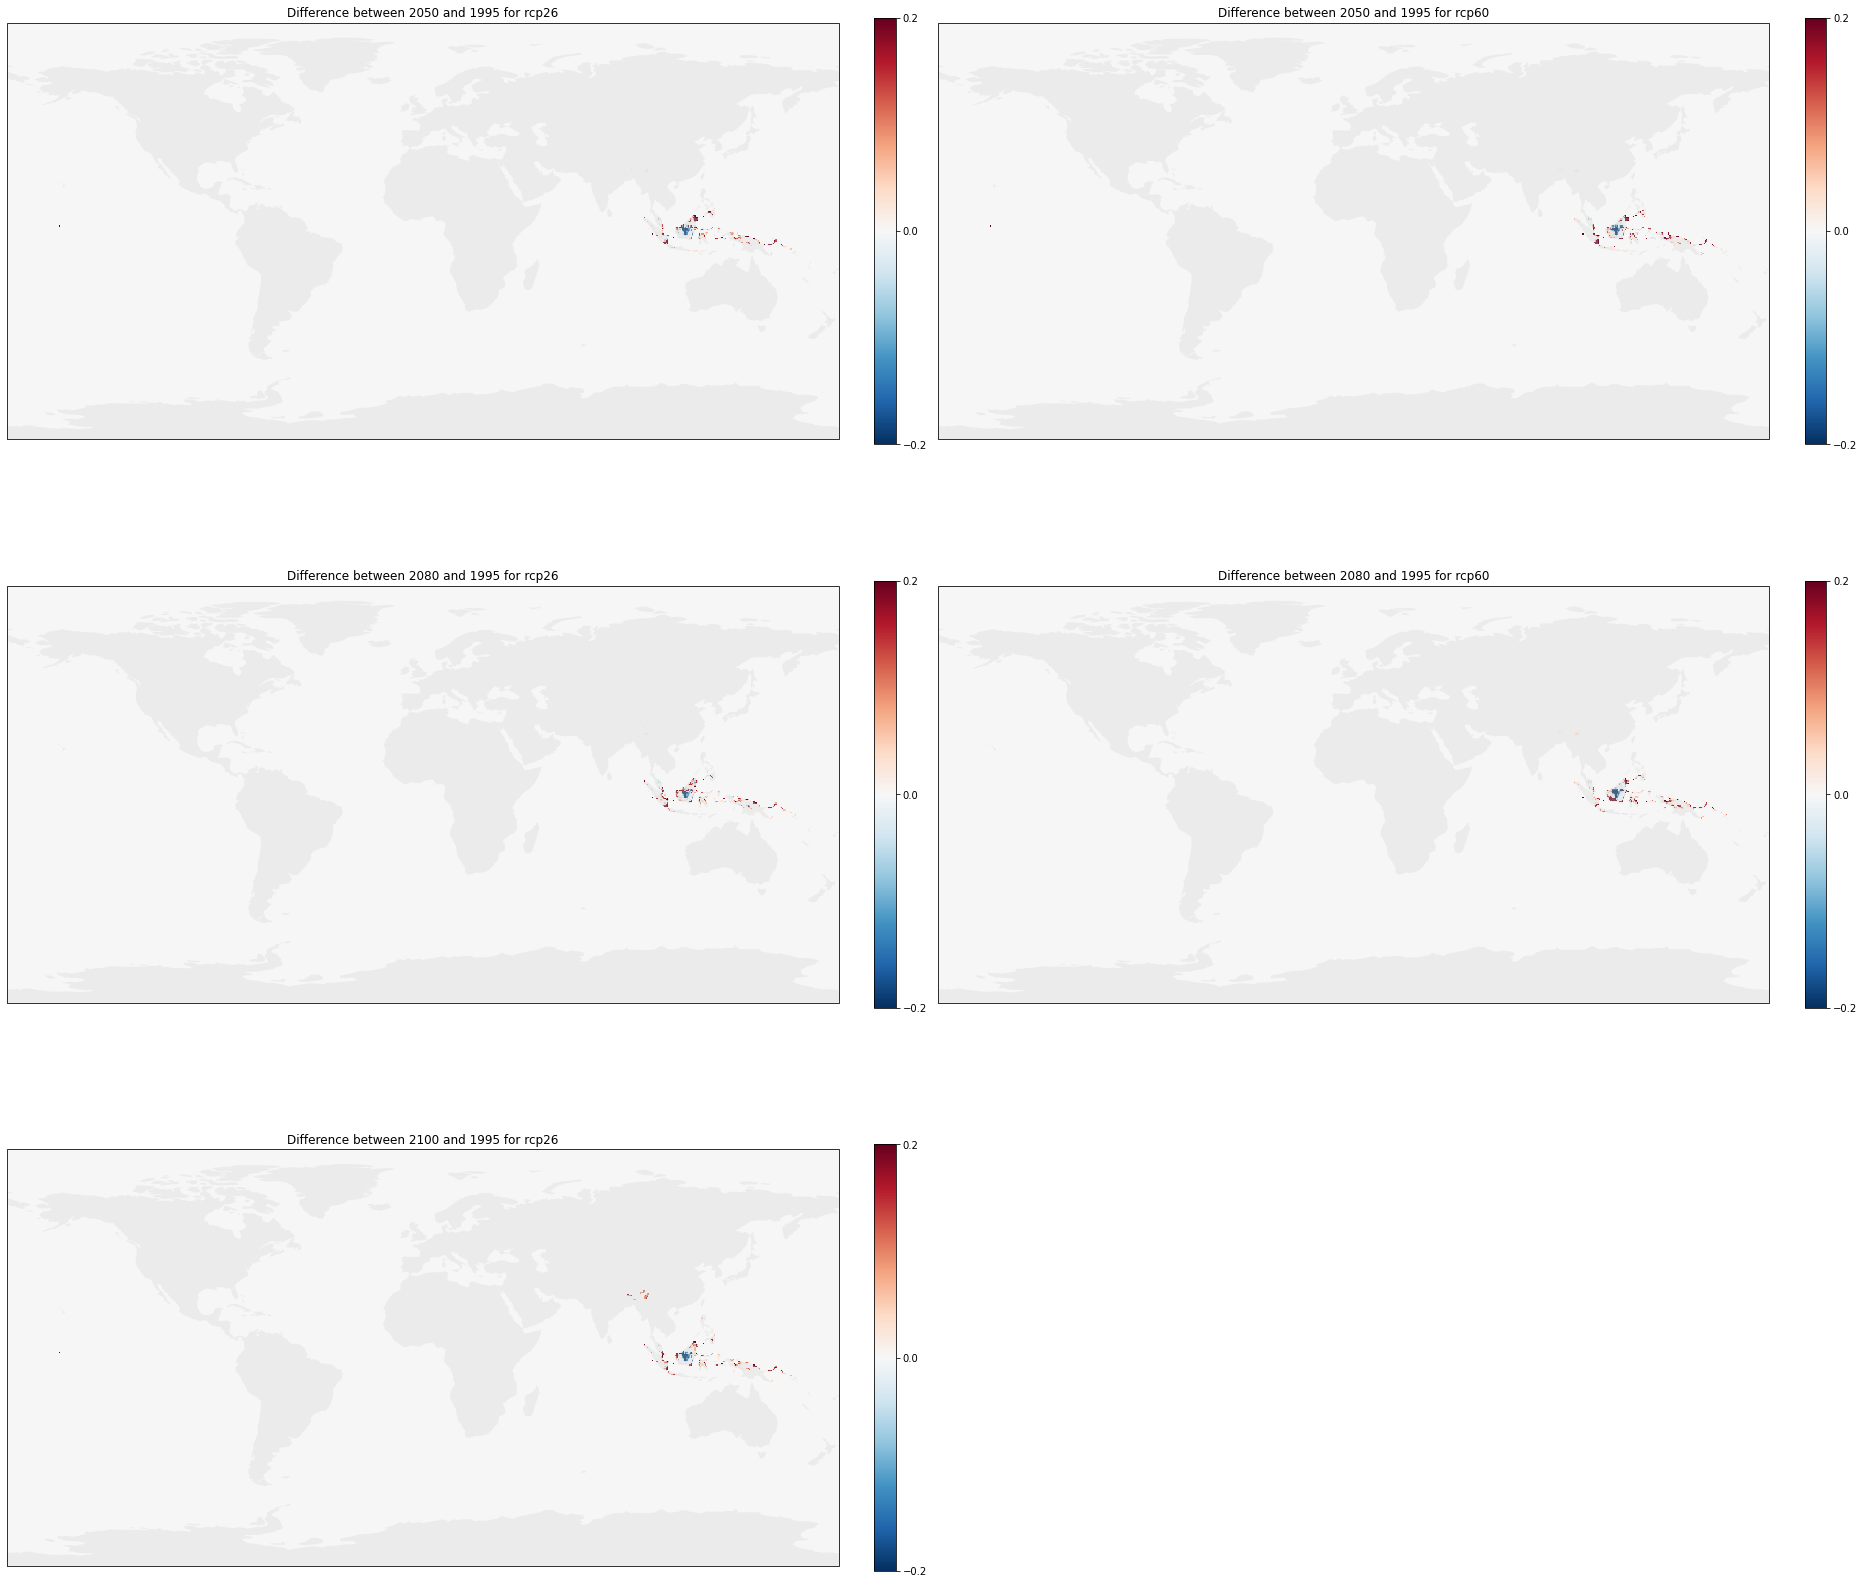

In [5]:
#newvalue
historical_time = 1146
future_times = [35, 65, 85]
scenarios = ["rcp26", "rcp60"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/EWEMBI/{}_[{}].nc"

mean_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26", "rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]

    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue
            
        mean_future = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
        difference = mean_future - mean_hist
        ax = axes.flatten()[plot_idx]
        im = ax.pcolormesh(difference['lon'].values, difference['lat'].values, difference.values, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.2, vmax=0.2)

        countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
        ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
        cbar.set_ticks([-0.2, 0, 0.2])

        plot_idx += 1
axes.flatten()[-1].set_visible(False)

plt.tight_layout()
plt.show()


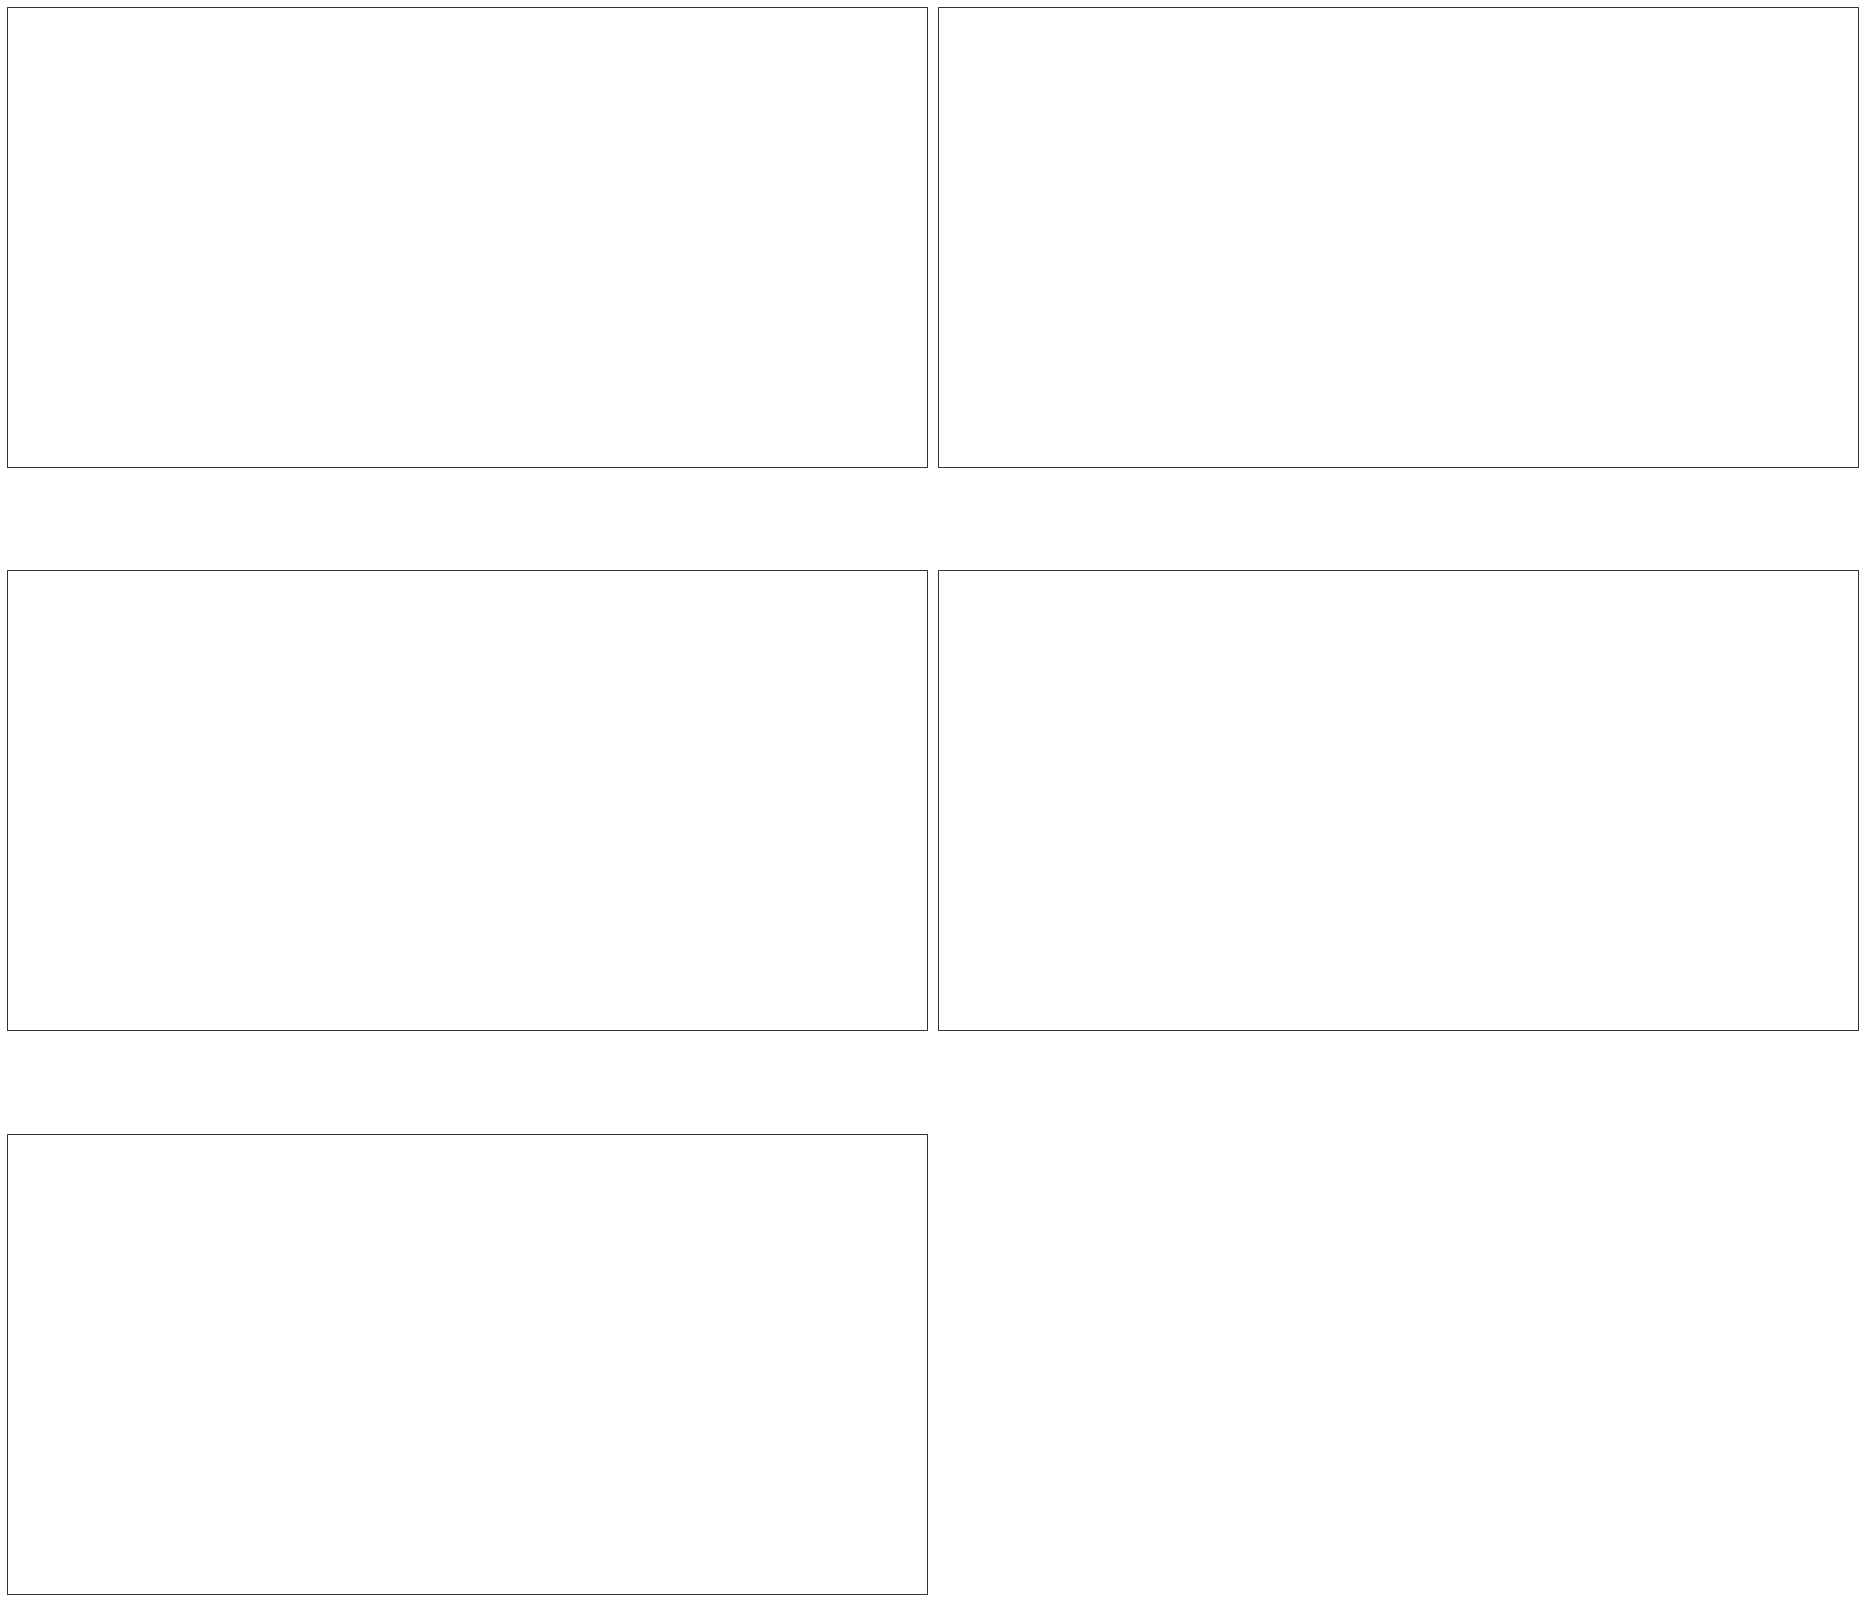

In [17]:
#newvalue
historical_time = 1146
future_times = [35, 65]
scenarios = ["rcp26", "rcp60"]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/EWEMBI/{}_[{}].nc"

mean_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26", "rcp60"]

    for scenario in scenarios:
        
        mean_rcp26 = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario="rcp26")
        mean_rcp60 = newvalue_fun(future_time, model, netcdf_path_format_future, is_historical=False, scenario="rcp60")
        difference = mean_rcp60 - mean_rcp26
        im = ax.pcolormesh(difference['lon'].values, difference['lat'].values, difference.values, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.2, vmax=0.2)

        countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
        ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
        cbar.set_ticks([-0.2, 0, 0.2])

        plot_idx += 1
axes.flatten()[-1].set_visible(False)

plt.tight_layout()
plt.show()


In [6]:
#sum_bin 

def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
    newvalue_dict = {model_name: {} for model_name in model_names}
    sum_bin_dict = {model_name: {} for model_name in model_names}

    for model_name in model_names:
        for species_name in species_names:
            if is_historical:
                ds = xr.open_dataset(netcdf_path_format.format(model, species_name, time), decode_times=False)
            else:
                ds = xr.open_dataset(netcdf_path_format.format(model, model_name, scenario, species_name, time), decode_times=False)
            sum_bin = ds["sum_bin"]
            sum_bin_dict[model_name][species_name] = sum_bin

    projections_dict = {}


    for species_name in species_names:
        sum_bin_list = []
        for model_name in model_names:
            sum_bin = sum_bin_dict[model_name][species_name]
            sum_bin_list.append(sum_bin)
        sum_bin_concat = xr.concat(sum_bin_list, dim="model")
        mean_sum_bin = sum_bin_concat.mean(dim="model")
        projections_dict[species_name] = mean_sum_bin

    mean_sum_bin_list = list(projections_dict.values())
    mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").mean(dim="species")

    return mean_sum_bin



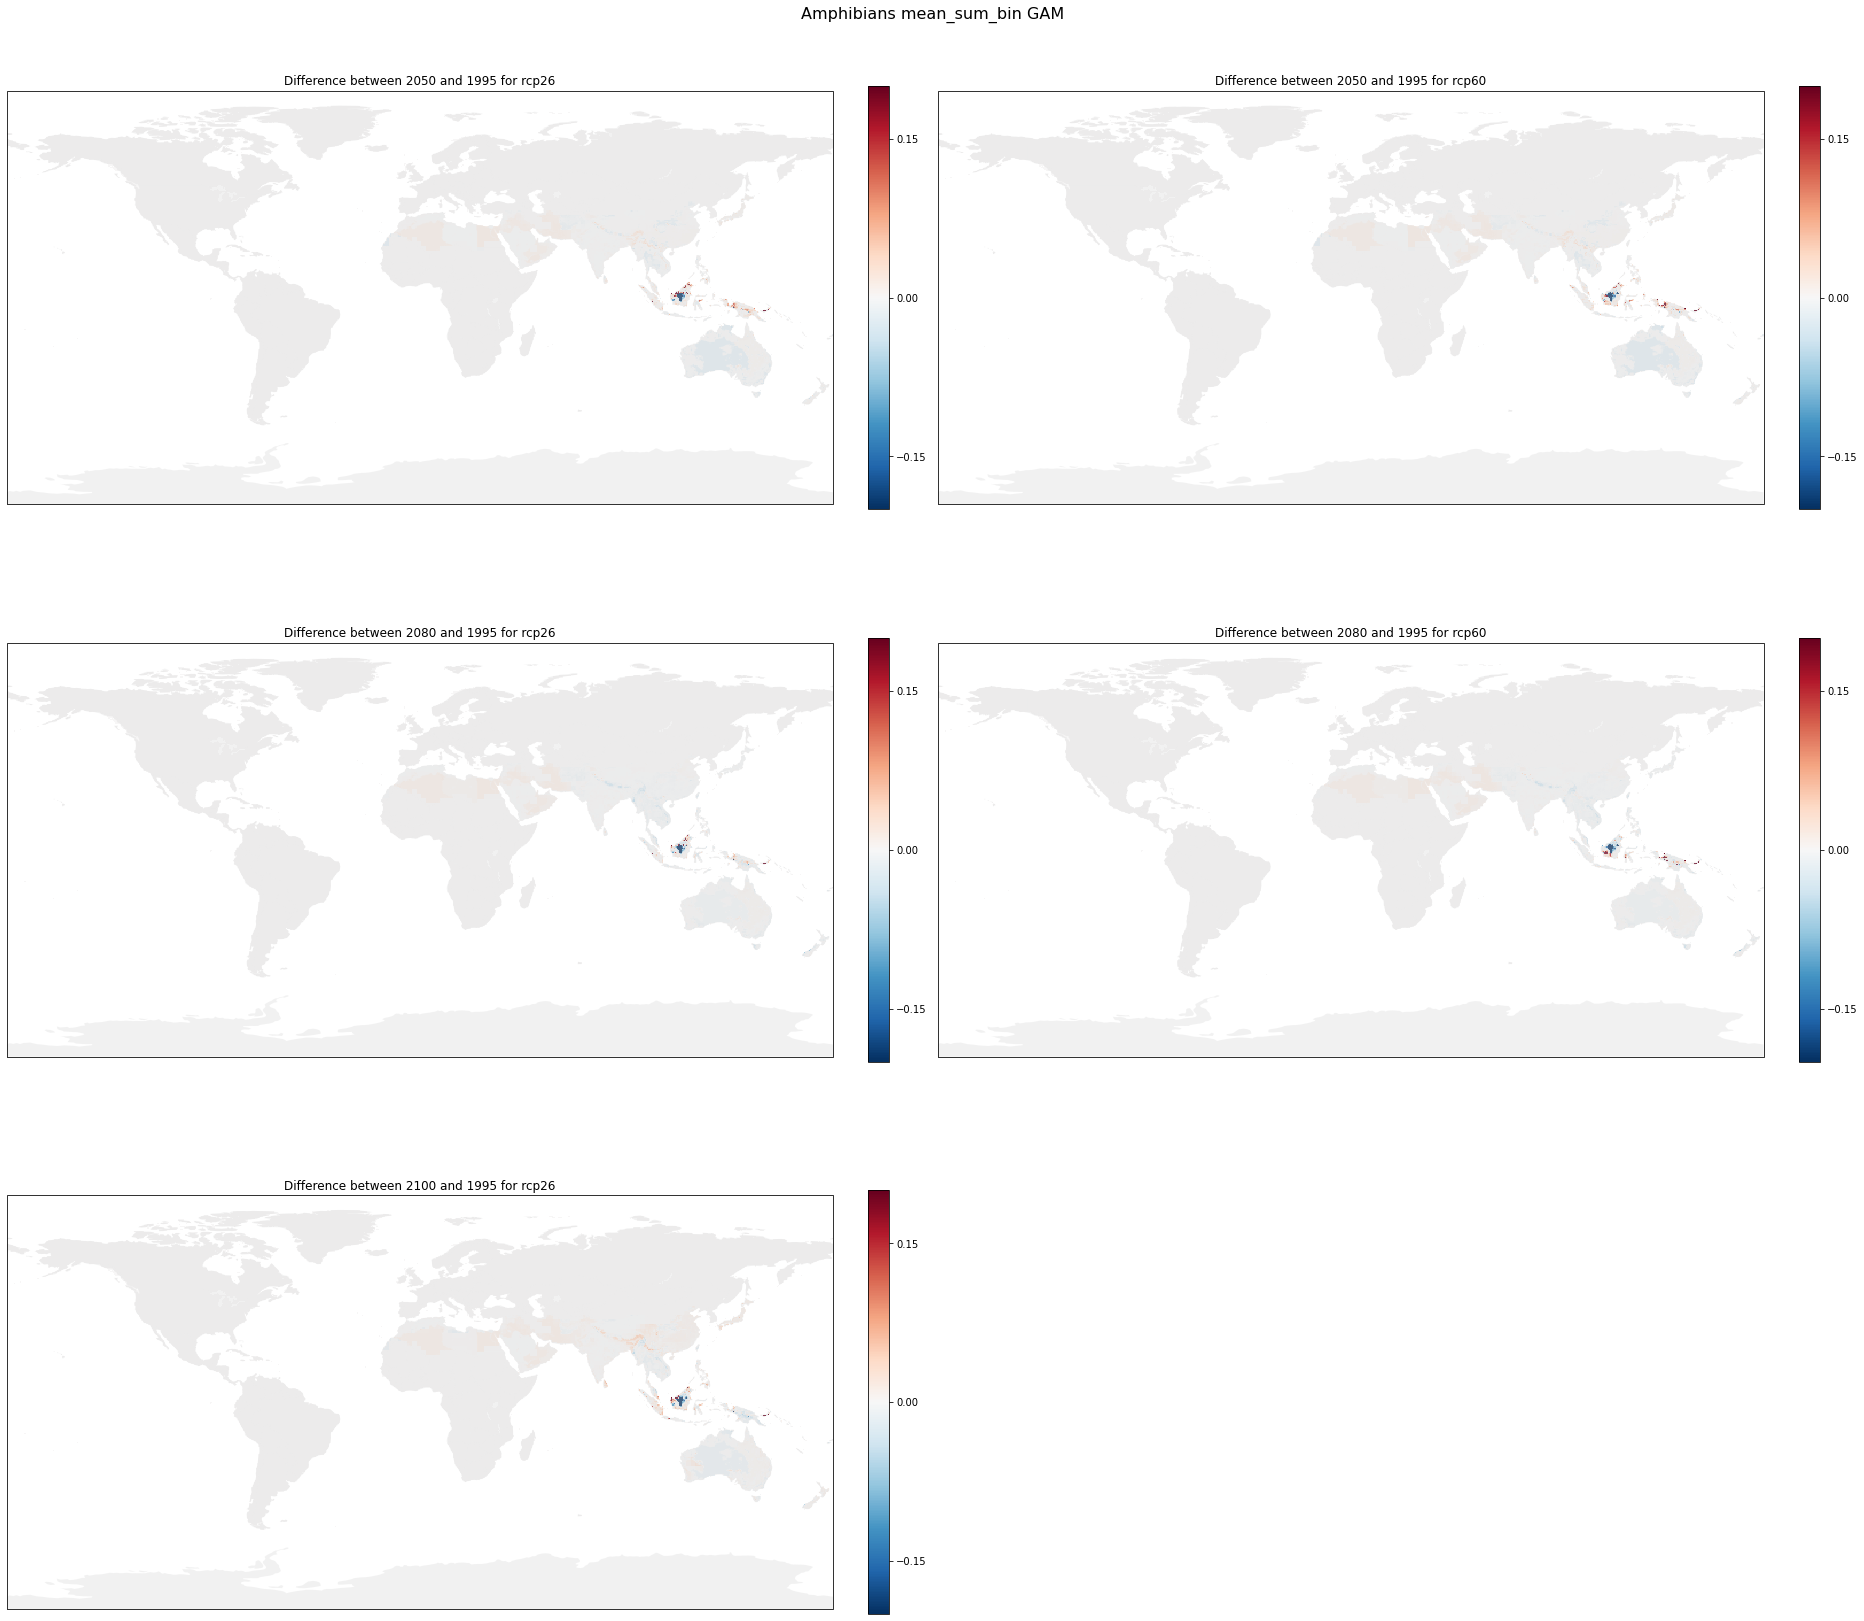

In [7]:
#sum_bin
historical_time = 1146
future_times = [35, 65, 85]
scenarios = ["rcp26", "rcp60"]
model="GBM"
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/Amphibians/EWEMBI/{}_[{}].nc"

mean_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26", "rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]

    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue
            

        mean_future = calculate_mean(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)

        # Select the 0th time slice in mean_future and mean_hist data arrays
        mean_future_slice = mean_future.isel(time=0)
        mean_hist_slice = mean_hist.isel(time=0)

        difference = mean_future_slice - mean_hist_slice
        ax = axes.flatten()[plot_idx]
        im = difference.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", add_colorbar=False, vmin=-0.2, vmax=0.2)

        countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
        ax.set_title(f"Difference between {year_indices[future_time]} and {year_indices[historical_time]} for {scenario}")

        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04)
        cbar.set_ticks([-0.15, 0, 0.15])

        plot_idx += 1

# Hide the last (empty) subplot
axes.flatten()[-1].set_visible(False)
plt.suptitle('Amphibians mean_sum_bin GAM', size=16)

plt.tight_layout()
plt.show()


In [15]:
mean_sum_bin.plot()

NameError: name 'mean_sum_bin' is not defined

In [146]:
test=mean_future-mean_hist

In [147]:
test

<xarray.DataArray 'sum_bin' (time: 0, lat: 360, lon: 720)>
array([], shape=(0, 360, 720), dtype=float64)
Coordinates:
  * time     (time) float64 
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

In [68]:
time=[65]
#get the species_names in xx_xx format
for model in models :
    for model_name in model_names:
                        convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                        dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/new/" 

                        dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/Mammals_" + model +"_results_climate/"
                        available_file = os.listdir(dir_species)
                        available_names = [x.split(".csv")[0] for x in available_file]

                        formatted_names = []

                        for species_name in available_names:
                            split_species_name = species_name.split("_")[:2]
                            formatted_species_name = "_".join(split_species_name)
                            formatted_names.append(formatted_species_name)
species_names=formatted_names[:5]    

dir_path="/storage/scratch/users/ch21o450/data/LandClim_Output/"
# create empty dictionaries to store the data arrays for each model
newvalue_dict = {model_name: {} for model_name in model_names}
sum_bin_dict = {model_name: {} for model_name in model_names}

# loop over the model names
for model_name in model_names:
    # loop over the species names
    for species_name in species_names:
        # read in the netCDF file
        ds = xr.open_dataset(
            dir_path + model + "/" + taxas[0]  +"/" + model_name + "/" + scenarios[0] + "/"
            + species_name + "_" +  str(time) +".nc" , decode_times=False
        )
        # extract the newvalue and sum_bin data arrays for the 35th time step
        newvalue = ds["newvalue"]
        sum_bin = ds["sum_bin"]
        
        # add the data arrays to the dictionaries for the current model and species
        newvalue_dict[model_name][species_name] = newvalue
        sum_bin_dict[model_name][species_name] = sum_bin

# create an empty dictionary to store the projections for each species
projections_dict = {}

# loop over the species names
for species_name in species_names:
    # create an empty list to store the sum_bin data arrays for the current species
    sum_bin_list = []
    # loop over the model names and append the sum_bin data array to the list
    for model_name in model_names:
        sum_bin = sum_bin_dict[model_name][species_name]
        sum_bin_list.append(sum_bin)
    # concatenate the sum_bin data arrays along a new dimension called "model"
    sum_bin_concat = xr.concat(sum_bin_list, dim="model")
    # take the mean of the sum_bin data array along the "model" dimension
    mean_sum_bin = sum_bin_concat.mean(dim="model")
    # add the mean sum_bin data array to the projections dictionary for the current species
    projections_dict[species_name] = mean_sum_bin


In [69]:
time=[1146]

dir_path="/storage/scratch/users/ch21o450/data/LandClim_Output/"
# create empty dictionaries to store the data arrays for each model
newvalue_dict_hist = {model_name: {} for model_name in model_names}
sum_bin_dict_hist = {model_name: {} for model_name in model_names}

# loop over the model names
for model_name in model_names:
    # loop over the species names
    for species_name in species_names:
        # read in the netCDF file
        ds = xr.open_dataset(
            dir_path + model + "/" + taxas[0]  +"/EWEMBI/"
            + species_name + "_" +  str(time) +".nc" , decode_times=False
        )
        # extract the newvalue and sum_bin data arrays for the 35th time step
        newvalue = ds["newvalue"]
     
        
        # add the data arrays to the dictionaries for the current model and species
        newvalue_dict[model_name][species_name] = newvalue
     
        # create an empty dictionary to store the projections for each species
projections_dict = {}

# loop over the species names
for species_name in species_names:
    # create an empty list to store the sum_bin data arrays for the current species
    value_list = []
    # loop over the model names and append the sum_bin data array to the list
    for model_name in model_names:
        value_bin = newvalue_dict[model_name][species_name]
        value_list.append(value_bin)
    # concatenate the sum_bin data arrays along a new dimension called "model"
    value_bin_concat = xr.concat(value_list, dim="model")
    # take the mean of the sum_bin data array along the "model" dimension
    mean_value_bin = value_bin_concat.mean(dim="model")
    # add the mean sum_bin data array to the projections dictionary for the current species
    projections_dict[species_name] = mean_value_bin
value_bin_list = list(projections_dict.values())
mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")


In [70]:
past_future=mean_sum_bin -mean_value_bin 

In [188]:
past_future35 = mean_value_bin  - mean_sum_bin

In [192]:
past_future65 = mean_value_bin  - mean_sum_bin

In [197]:
past_future85 = mean_sum_bin -mean_value_bin 

In [42]:
past_future=past_future65

In [24]:
#past_future100 = mean_sum_bin -mean_value_bin 

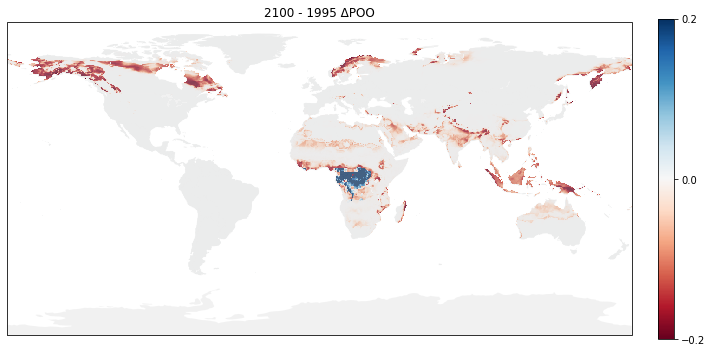

In [71]:
#martes orig POO
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot data on the first subplot
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
im1 = past_future.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap="RdBu", add_colorbar=False, vmin=-0.2, vmax=0.2)

cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)
cbar1.set_ticks([-0.2,0,0.2])
countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)

ax1.set_title("2100 - 1995 \u0394POO")

plt.tight_layout()
#fig.savefig("/storage/homefs/ch21o450/figures/phd_Day/martes_melampus_proj_range_6.0.png")

In [ ]:
#elephant only
#read in the IUCN-LUH2 conversion table
convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")

#read in the IUCN Habitat Classifications
dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" 

#available_file= os.listdir(dir_habclass)
available_files_iucn = species_name.replace(" ", "_") + ".txt"
available_files_iucn

IUCN = pd.read_csv('/storage/homefs/ch21o450/IUCN/Habitat_Classifications/loxodonta_africana.csv')
new_colnames = {"name":"unnamed","result.code":"name","result.habitat":"result.code","result.suitability":"result.habitat","result.season":"result.suitability","result.majorimportance":"result.season","result.majorimportance":"result.majorimportance"}

IUCN.rename(columns=new_colnames, inplace=True)
convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')


In [ ]:
#elephant Africa
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(species_name, fontsize=12)
xmin, ymin, xmax, ymax = countries[countries["name"] == "Africa"].total_bounds
ax1.set_xlim(-20, 60)
ax1.set_ylim(-40,40)

# Plot data on the first subplot
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
im1 = merged.newvalue.where(landmask).plot(ax=ax1, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.035, pad=0.04)
cbar1.set_ticks([0,  0.76])
countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
kenya = countries[countries["name"] == "Kenya"]
kenya.plot(ax=ax1, edgecolor="red", facecolor="none", lw=2, zorder=2)
ax1.set_title("probability of occurrence RCP2.6 2050")

plt.tight_layout()
fig.savefig("/storage/homefs/ch21o450/figures/phd_Day/martes_melampus_proj_range.png")

In [ ]:
#elephant 
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(species_name, fontsize=16)
xmin, ymin, xmax, ymax = countries[countries["name"] == "Africa"].total_bounds
ax1.set_xlim(-20, 60)
ax1.set_ylim(-40,40)

# Plot data on the first subplot
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
im1 = added_hab1.where(landmask).plot(ax=ax1, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)
cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)
cbar1.set_ticks([0,  1])
countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
kenya = countries[countries["name"] == "Kenya"]
kenya.plot(ax=ax1, edgecolor="red", facecolor="none", lw=2, zorder=2)
ax1.set_title("primf,secdf RCP2.6 2050")

# Plot data on the second subplot
ax2.set_xlim(-20, 60)
ax2.set_ylim(-40,40)
im2 = added_hab2.where(landmask).plot(ax=ax2, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)
cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04)
cbar2.set_ticks([0,  1])
countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
kenya = countries[countries["name"] == "Kenya"]
kenya.plot(ax=ax2, edgecolor="red", facecolor="none", lw=2, zorder=2)
ax2.set_title("primn,secdn RCP2.6 2050")

# Plot data on the third subplot
ax3.set_xlim(-20, 60)
ax3.set_ylim(-40,40)
im3 = added_hab3.where(landmask).plot(ax=ax3, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)
cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04)
cbar3.set_ticks([0,1])
countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
kenya = countries[countries["name"] == "Kenya"]
kenya.plot(ax=ax3, edgecolor="red", facecolor="none", lw=2, zorder=2)
ax3.set_title("primf,secdf,primn,secdn RCP2.6 2050")

plt.tight_layout()
fig.savefig("/storage/homefs/ch21o450/figures/phd_Day/loxodonta_africana_rcp2.6_2050.png")

In [ ]:
#threee in one
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(species_name, fontsize=12)

# Plot data on the first subplot
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
im1 = dpctlake.where(landmask).plot(ax=ax1, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)
cbar = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04)
cbar.set_ticks([0,  1])
countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
ax1.set_title("primf RCP6.0 2050")

# Plot data on the second subplot
im2 = sec_bin.where(landmask).plot(ax=ax2, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)
cbar = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04)
cbar.set_ticks([0,  1])
countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
ax2.set_title("secdf RCP6.0 2050")

# Plot data on the third subplot
im3 = added_hab.where(landmask).plot(ax=ax3, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)
cbar = plt.colorbar(im3, ax=ax3, fraction=0.024, pad=0.04)
cbar.set_ticks([0,  1, 2])
countries.plot(ax=ax3, color="lightgray", zorder=1, alpha=0.3)
ax3.set_title("primf + secdf RCP6.0 2050")

plt.tight_layout()
fig.savefig("/storage/homefs/ch21o450/figures/phd_Day/martes_melampus_rcp6.0_2050.png")

In [ ]:
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))



fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_title(species_name)
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
# Plot the data on a map
im = dpctlake.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)

# Plot the country borders

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_ticks([0,  1])
countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
# Set the title of the plot
plt.title("primf RCP8.5 2050")

# Show the plot
plt.show()

countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))



fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
# Plot the data on a map
im = sec_bin.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)

# Plot the country borders

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_ticks([0,  1])
countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
# Set the title of the plot
plt.title("secdf RCP8.5 2050")

# Show the plot
plt.show()

countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))



fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
# Plot the data on a map
im = added_hab.where(landmask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=False)

# Plot the country borders

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_ticks([0,  1,2])
countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
# Set the title of the plot
plt.title("primf + secdf RCP8.5 2050")

# Show the plot
plt.show()



In [ ]:
import xarray as xr 
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray
import cartopy.crs as ccrs
species =rioxarray.open_rasterio("/storage/homefs/ch21o450/data/SpeciesData/Martes_melampus_0.5.tif", mask_and_scale=True)
#species_new = species.plot(xlim=(122, 150), ylim=(30, 45))
species2= species.isel(band=0)
da_species = xr.DataArray(species2, coords=[species2.y, species2.x], dims=['lats','lons'])

In [ ]:
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot data on the first subplot
#cmap = plt.colors.ListedColormap(['white', 'green'])
im1 = da_species.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap="Greens", add_colorbar=True, vmin=0,vmax=1)
ax1.set_xlim([120,150])
ax1.set_ylim([20,50])

countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)

ax1.set_title("Martes melampus IUCN Range Map")

# Set the x-axis and y-axis tick labels
xticks = np.arange(120, 151, 10)
yticks = np.arange(20, 51, 10)
ax1.set_xticks(xticks, crs=ccrs.PlateCarree())
ax1.set_yticks(yticks, crs=ccrs.PlateCarree())

ax1.set_xticklabels(xticks)
ax1.set_yticklabels(yticks)

# Add a title
#ax.set_title("Martes Melampus IUCN Range Map")

# Save the figure
plt.tight_layout()

fig.savefig("/storage/homefs/ch21o450/figures/phd_Day/martes_melampus_proj_range_japan.png")


# Get the unique latitude and longitude values from the dataframe
latitudes = df['lat'].unique()
longitudes = df['lon'].unique()

# Loop over the rows in the dataframe
for i, row in df.iterrows():
    # Get the latitude and longitude of the current row
    lat = row['lat']
    lon = row['lon']

    # Check if the latitude exists in the latitudes array
    if lat in latitudes:
        # Get the index of the latitude in the latitudes array
        lat_index = np.where(latitudes == lat)
        lat_vals = np.where(longitudes == lon)
    else:
        # Add the new latitude to the latitudes array
        latitudes = np.append(latitudes, lat)
        lat_index = latitudes.size - 1
    
    # Check if the longitude exists in the longitudes array
    if lon in longitudes:
        # Get the index of the longitude in the longitudes array
        lon_index = np.where(longitudes == lon)
        lon_vals = np.where(longitudes == lon)
    else:
        # Add the new longitude to the longitudes array
        longitudes = np.append(longitudes, lon)
        lon_index = longitudes.size - 1
    
    # Fill the np_empty array with the value from the current row
        selection = df[(df['lat'] == lat) & (df['lon'] == lon)]
        if not selection.empty:
        #newvalue_array[i, j] = selection['vals'].values[0]
            np_empty[lat_index, lon_vals] = selection['vals'].values

# Convert the unique latitude and longitude values into a coordinate array
latitude_coords = xr.DataArray(latitudes, dims='lat')
longitude_coords = xr.DataArray(longitudes, dims='lon')

"""""
# Extract unique latitudes and longitudes from the dataframe
latitudes = df['lat'].unique()
longitudes = df['lon'].unique()

# Create an empty xarray Dataset with dimensions for latitude and longitude
ds = xr.Dataset({'newvalue': (['lat', 'lon'], np.zeros((len(latitudes), len(longitudes))))},
                coords={'lat': latitudes, 'lon': longitudes})

# Loop over the latitudes and longitudes, extract the corresponding values from the dataframe and add to the Dataset
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        selection = df[(df['lat'] == lat) & (df['lon'] == lon)]
        if not selection.empty:
            ds.newvalue[i, j] = selection['vals'].values[0]
            
"""

lats = np.arange(-180,180,0.5)
lons = np.arange(-360,360,0.5)
